In [1]:
# modules for structure decoration
import pandas as pd
import os
import itertools
from tqdm.notebook import tqdm
import networkx as nx
import glob
from glob import iglob
from copy import deepcopy
from collections import defaultdict

from pymatgen.core import Composition, Structure
from pymatgen.analysis import local_env

In [2]:
# print(f"pymatgen version: {pymatgen.__version__}")
import pip
pip.main(["show","pymatgen"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Name: pymatgen
Version: 2022.0.8
Summary: Python Materials Genomics is a robust materials analysis code that defines core object representations for structures and molecules with support for many electronic structure codes. It is currently the core analysis code powering the Materials Project (https://www.materialsproject.org).
Home-page: http://www.pymatgen.org
Author: Pymatgen Development Team
Author-email: ongsp@eng.ucsd.edu
License: MIT
Location: /home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages
Requires: monty, scipy, numpy, tabulate, spglib, ruamel.yaml, pandas, plotly, requests, uncertainties, palettable, sympy, networkx, matplotlib
Required-by: 


0

In [8]:
# want to maximize the volume around only the conducting ions
conducting_ions = set(['Li', 'Na', 'K', 'Mg', 'Zn'])
anions = set(['F', 'Cl', 'Br', 'I', 'O', 'S', 'N', 'P'])
framework_cations = set(['Sc', 'Y', 'La', 'Ti', 'Zr', 'Hf', 'W', 'Zn', 'Cd', 'Hg', 'B', 'Al', 'Si', 'Ge', 'Sn', 'P', 'Sb'])
elements = conducting_ions | anions | framework_cations
# sort by the length of the string, so that multiple letter elements come first
elements = sorted(elements, key=len, reverse=True)
print(elements)

['Ge', 'Hg', 'Na', 'La', 'Br', 'Cd', 'Zr', 'Al', 'Si', 'Sb', 'Cl', 'Zn', 'Li', 'Mg', 'Hf', 'Sc', 'Sn', 'Ti', 'O', 'K', 'N', 'B', 'Y', 'W', 'F', 'S', 'P', 'I']


In [45]:
G = nx.DiGraph()
G2 = nx.DiGraph()

G = nx.read_edgelist(
    "inputs/elements_to_compositions.edgelist.gz", delimiter='\t', data=False,
    create_using=G,
)
print(f'{G.number_of_nodes()} nodes, {G.number_of_edges()} edges')

G2 = nx.read_edgelist(
    "inputs/comp_type_to_decorations.edgelist.gz", delimiter='\t', data=False,
    create_using=G2,
)
print(f'{G2.number_of_nodes()} nodes, {G2.number_of_edges()} edges')

159870 nodes, 178521 edges
16388 nodes, 16316 edges


In [46]:
G.has_node("root")

True

In [41]:
G.add_edge("","Li")

In [6]:
# also load the mapping from composition to composition type
working_dir = 'inputs'
df_comp = pd.read_csv(f'{working_dir}/compositions.csv')
df_comp

,composition,stoichiometry,comp_type
0,Li1Sc1F4,114,_1_1_4
1,Li1Sc1Cl4,114,_1_1_4
2,Li1Sc1Br4,114,_1_1_4
3,Li1Sc1I4,114,_1_1_4
4,Li1Sc1O2,112,_1_1_2
...,...,...,...
138771,Zn5O2P2,522,_2_2_5
138772,Zn5S2N2,522,_2_2_5
138773,Zn5S2P2,522,_2_2_5
138774,Zn6N1P3,613,_1_3_6


In [7]:
compositions = df_comp['composition'].to_list()
comp_types = set(df_comp['comp_type'].to_list())
comp_to_comp_type = dict(zip(df_comp['composition'], df_comp['comp_type']))

In [20]:
leaf_nodes = [n for n in G.nodes() if G.out_degree(n) == 0]
leaf_nodes[:10]

['K1Cl1',
 'K3F2Cl1',
 'K5F2Cl3',
 'K5F4Cl1',
 'K4F3Cl1',
 'K3F1Cl2',
 'K5F3Cl2',
 'K5F1Cl4',
 'K4F1Cl3',
 'K2F1Cl1']

In [ ]:
all_paths = []
for c in conducting_ions:
    for leaf in leaf_nodes:
        simple_paths = nx.all_simple_paths(G, c, leaf)
        all_paths += list(simple_paths)
        
print(len(all_paths))

In [14]:
# now see if we can generate all of the possible decorations using these two graphs
decorations = 0
# perform a depth-first search over the tree
for root in conducting_ions:
    n = root
    while True:
        for n2 in G.neighbors(n):
            print(n, n2)
            break
        break
    break

Zn ('Cl', 'Zn')


In [25]:
G.has_node(n)

True

In [40]:
path = []
root_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]
print(root_nodes)

['K', 'Na', 'Li', 'Mg', 'Zn']


In [28]:
leaf_nodes2 = [n for n in G2.nodes() if G2.out_degree(n) == 0]
leaf_nodes2[:10]

['_1_3_6|POSCAR_sg167_icsd_423672|1',
 '_1_3_6|POSCAR_sg205_icsd_065968|1',
 '_1_3_6|POSCAR_sg203_icsd_019068|1',
 '_1_3_6|POSCAR_sg2_icsd_411500|1',
 '_1_3_6|POSCAR_sg162_icsd_062027|1',
 '_1_3_6|POSCAR_sg63_icsd_030712|1',
 '_1_3_6|POSCAR_sg182_icsd_632802|1',
 '_1_3_6|POSCAR_sg87_icsd_262076|1',
 '_1_3_6|POSCAR_sg15_icsd_409384|1',
 '_1_3_6|POSCAR_sg2_icsd_300275|1']

In [35]:
# generate a random cyrstal by choosing a random action (first action) at each step
n = list(root_nodes)[0]
path = [n]
while n not in leaf_nodes:
    n = list(G.neighbors(n))[0]
    path.append(n)
    print(path)
    
# now loop through the second graph
comp_type = comp_to_comp_type[n]
print(comp_type)
n = comp_type
while n not in leaf_nodes2:
    n = list(G2.neighbors(n))[0]
    path.append(n)
    print(path)

['Zn', "('Cl', 'Zn')"]
['Zn', "('Cl', 'Zn')", "('Cl', 'F', 'Zn')"]
['Zn', "('Cl', 'Zn')", "('Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Zn')"]
['Zn', "('Cl', 'Zn')", "('Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Hg', 'Zn')"]
['Zn', "('Cl', 'Zn')", "('Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Hg', 'Zn')", 'Zn1Hg1Al1F1Cl6']
_1_1_1_1_6
['Zn', "('Cl', 'Zn')", "('Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Hg', 'Zn')", 'Zn1Hg1Al1F1Cl6', '_1_1_1_1_6|monoclinic']
['Zn', "('Cl', 'Zn')", "('Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Hg', 'Zn')", 'Zn1Hg1Al1F1Cl6', '_1_1_1_1_6|monoclinic', '_1_1_1_1_6|POSCAR_sg11_icsd_084411']
['Zn', "('Cl', 'Zn')", "('Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Zn')", "('Al', 'Cl', 'F', 'Hg', 'Zn')", 'Zn1Hg1Al1F1Cl6', '_1_1_1_1_6|monoclinic', '_1_1_1_1_6|POSCAR_sg11_icsd_084411', '_1_1_1_1_6|POSCAR_sg11_icsd_084411|1']


In [48]:
# Check to see what the biggest out degrees are
out_degrees = {G.out_degree(n) for n in G.nodes()]
print(max(out_degrees))

43


In [52]:
out_degrees = dict(G.out_degree())

In [55]:
S = pd.Series(out_degrees)
S.head()

root    5
K       8
Li      8
Na      8
Mg      8
dtype: int64

In [60]:
idxmax = S.idxmax()
print(idxmax, S[idxmax], list(G.neighbors(idxmax)))

('Cd', 'Mg', 'O', 'S') 43 ["('Cd', 'Mg', 'O', 'S', 'W')", "('Cd', 'Mg', 'O', 'S', 'Zr')", "('Cd', 'Hf', 'Mg', 'O', 'S')", "('Cd', 'Mg', 'O', 'S', 'Sc')", "('Cd', 'Hg', 'Mg', 'O', 'S')", "('Cd', 'Mg', 'O', 'S', 'Si')", "('Al', 'Cd', 'Mg', 'O', 'S')", "('Cd', 'Mg', 'O', 'S', 'Sn')", "('Cd', 'La', 'Mg', 'O', 'S')", "('Cd', 'Ge', 'Mg', 'O', 'S')", "('Cd', 'Mg', 'O', 'S', 'Ti')", "('B', 'Cd', 'Mg', 'O', 'S')", "('Cd', 'Mg', 'O', 'S', 'Y')", "('Cd', 'Mg', 'O', 'S', 'Zn')", 'Mg2Cd1O2S1', 'Mg2Cd2O3S1', 'Mg3Cd2O1S4', 'Mg1Cd4O4S1', 'Mg1Cd3O2S2', 'Mg3Cd2O4S1', 'Mg1Cd4O3S2', 'Mg1Cd2O1S2', 'Mg2Cd3O4S1', 'Mg2Cd3O3S2', 'Mg1Cd3O3S1', 'Mg4Cd1O3S2', 'Mg3Cd1O1S3', 'Mg4Cd1O4S1', 'Mg1Cd3O1S3', 'Mg3Cd2O2S3', 'Mg2Cd3O2S3', 'Mg3Cd2O3S2', 'Mg1Cd4O2S3', 'Mg1Cd2O2S1', 'Mg4Cd1O2S3', 'Mg2Cd1O1S2', 'Mg2Cd3O1S4', 'Mg1Cd4O1S4', 'Mg4Cd1O1S4', 'Mg3Cd1O3S1', 'Mg2Cd2O1S3', 'Mg1Cd1O1S1', 'Mg3Cd1O2S2']


In [61]:
S2 = pd.Series(dict(G2.out_degree()))
S2.head()

_1_3_6                  7
_1_3_6|trigonal        14
_1_3_6|cubic            6
_1_3_6|triclinic        5
_1_3_6|orthorhombic    18
dtype: int64

In [73]:
len(S2[S2 > 50])

14

In [74]:
idxmax2 = S2.idxmax(10)
print(idxmax2)
# print(idxmax2, S2[idxmax2], list(G2.neighbors(idxmax2)))

_1_2|orthorhombic


In [76]:
S2.nlargest(14)

_1_2|orthorhombic                     122
_1_1_1_1_1|POSCAR_sg62_icsd_409579    120
_1_1_1_1_1|POSCAR_sg11_icsd_094400    120
_1_2|tetragonal                        89
_1_1_2|orthorhombic                    72
_1_2_4|orthorhombic                    69
_1_1_3|orthorhombic                    67
_1_2_3|orthorhombic                    62
_1_1|orthorhombic                      60
_1_2|hexagonal                         57
_1_1_4|orthorhombic                    56
_1_2_4|tetragonal                      54
_1_2|cubic                             54
_1_2_2|orthorhombic                    53
dtype: int64

In [68]:
import matplotlib.pyplot as plt

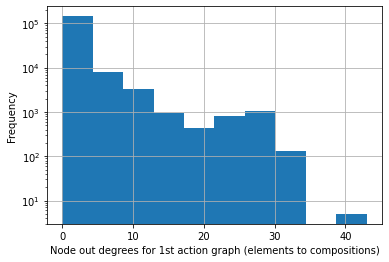

In [70]:
S.hist()
plt.xlabel("Node out degrees for 1st action graph (elements to compositions)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

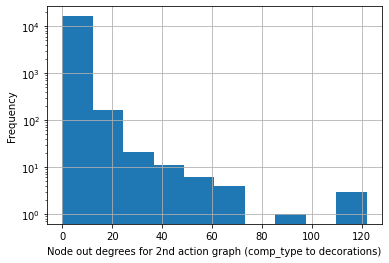

In [72]:
S2.hist()
plt.xlabel("Node out degrees for 2nd action graph (comp_type to decorations)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

In [50]:
# Check to see what the biggest out degrees are
out_degrees = [G2.out_degree(n) for n in G2.nodes()]
print(max(out_degrees))

122


In [114]:
import re
import numpy as np
comp = "Li1Sc1F4"
split = np.asarray(re.split('(\d+)',comp))
print(split)
elements = tuple(split[range(0, len(split)-1, 2)])
print(elements)
stoich = split[list(range(1,len(split),2))]
# sort the stoichiometry to get the correct order of the comp type
comp_type = '_' + '_'.join(map(str, sorted(map(int, stoich))))
print(comp_type)

['Li' '1' 'Sc' '1' 'F' '4' '']
('Li', 'Sc', 'F')
_1_1_4


## Store the cyrstal structures
Loading the crystal structure files and generating the new structures for each decoration take a significant amount of time.
May be able to speed up the process by pre-performing those actions


In [77]:
# First, to estimate how big the file will be, load all the icsd crystal structures and store them in a single JSON file
import pymatgen
from pymatgen.core import Composition, Structure
import glob

prototype_folder = '/projects/rlmolecule/shubham/icsd_prototypes_poscars/DB/'
comp_prototypes = defaultdict(set)
prototype_files = set()
for comp_type in comp_types:
    for poscar_file in glob.glob(f"{prototype_folder}/{comp_type}/*"):
        prototype_files.add(poscar_file)
        file_name = os.path.basename(poscar_file)
        comp_prototypes[comp_type].add(file_name)

print(f"{len(prototype_files)} prototype files")

4170 prototype files


In [93]:
structures = {}
for comp_type, poscar_files in tqdm(comp_prototypes.items()):
    for file_name in poscar_files:
        prototype_file = f"{prototype_folder}/{comp_type}/{file_name}"
        strc = Structure.from_file(prototype_file, primitive=False)

        structures[comp_type + '|' + file_name] = strc.as_dict()
#         break
#     break
# print(structures)
# as_dict

  0%|          | 0/72 [00:00<?, ?it/s]

In [83]:
# now store them in a single file
import json
import gzip

# https://pymatgen.org/usage.html#side-note-as-dict-from-dict
out_file = "inputs/icsd_prototypes.json.gz"
with gzip.open(out_file, 'w') as out:
    out.write(json.dumps(structures, indent=2).encode())

In [97]:
# read them back
with gzip.open(out_file, 'r') as f:
    structures_dict = json.loads(f.read().decode())

new_structures = {}
for key, structure_dict in structures_dict.items():
    new_structures[key] = Structure.from_dict(structure_dict)

In [98]:
len(new_structures)

4170

In [99]:
15000000 / 4170

3597.122302158273

In [100]:
# estimated size of structures file: 18GB. That's too much to store everything in RAM. 
5 * 3560 / 1000

17.8